In [1]:
import os
os.chdir(f'../')

In [2]:
from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
# from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Models.StyleGan2.model import Generator
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

In [3]:
BASE_PATH = './pretrained'
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + '/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + '/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + '/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + '/fake/small_image/'
W_DATA_DIR = BASE_PATH + '/fake/small_w/'
MODELS_DIR = BASE_PATH + '/Models/'

In [4]:
id_encoder = id_loss.IDLoss('./pretrained/model_ir_se50.pth')
# attr_encoder = torch.load('./pretrained/Models/attr_long1678731087.4649038_12.pt')
attr_encoder = torch.load('./pretrained/Models/attr_final.pt')
attr_encoder = Inception(attr_encoder)
discriminator = Discriminator()
mlp = LatentMapper()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
generator = Generator(GENERATOR_IMAGE_SIZE, 512, 8)
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)
mlp = torch.load('pretrained/Models/maper_final.pt')

Loading ResNet ArcFace


In [5]:
id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
generator = generator.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
discriminator = discriminator.eval()
generator = generator.eval()
mlp = mlp.eval()
landmark_encoder = landmark_encoder.eval()

In [6]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

convert_tensor = T.ToTensor()
transform = T.Resize((256,256))

def get_concat_vec(id_images, attr_images, id_encoder, attr_encoder):
    with torch.no_grad():
        id_vec = torch.squeeze(id_encoder.extract_feats((id_images*2)-1))
        attr_vec = torch.squeeze(attr_encoder(attr_images))
        test_vec = torch.cat((id_vec, attr_vec), dim=1)
        return test_vec

# Attribute Interpolation

In [7]:
def interpolate_attributes(id_img, attr_img1, attr_img2):
    id_image = transform(id_img)
    attr_image1 = transform(attr_img1)
    attr_image2 = transform(attr_img2)

    id_image = convert_tensor(id_image).to(Global_Config.device)
    attr_image1 = convert_tensor(attr_image1).to(Global_Config.device)
    attr_image2 = convert_tensor(attr_image2).to(Global_Config.device)

    id1 = torch.stack((id_image, attr_image1))
    id2 = torch.stack((id_image, attr_image2))
    atr1 = torch.stack((attr_image1, id_image))
    atr2 = torch.stack((attr_image2, id_image))

    concat_vec_cycled1 = get_concat_vec(id1, atr1, id_encoder, attr_encoder)
    concat_vec_cycled2 = get_concat_vec(id2, atr2, id_encoder, attr_encoder)

    with torch.no_grad():
        w1 = mlp(concat_vec_cycled1)[0]
        w2 = mlp(concat_vec_cycled2)[0]

    interpolated_w = []
    for i in range(8):
        interpolated_w.append(w1 + (w2 - w1) * (i / 7))
    interpolated_w = torch.stack(interpolated_w)

    generated_imgs = []
    for w in interpolated_w:
        generated_img = get_w_image(w, generator)
        generated_imgs.append(generated_img)
    generated_imgs = np.concatenate(np.array(generated_imgs), axis=1)
    return generated_imgs

In [8]:
def plot_attr_interpolation(generated_imgs, id_img, attr_img1, attr_img2):
    id_img = np.array(transform(id_img))
    attr_img1 = np.array(transform(attr_img1))
    attr_img2 = np.array(transform(attr_img2))

    fig, axes = plt.subplots(1, 4, figsize=(20, 20), gridspec_kw={'width_ratios': [1, 1, 8, 1]})
    axes[0].imshow(id_img)
    axes[0].set_title('Identity')
    axes[0].axis('off')
    axes[1].imshow(attr_img1)
    axes[1].set_title('Attribute 1')
    axes[1].axis('off')
    axes[2].imshow(generated_imgs)
    axes[2].set_title('Interpolation')
    axes[2].axis('off')
    axes[3].imshow(attr_img2)
    axes[3].set_title('Attribute 2')
    axes[3].axis('off')
    plt.subplots_adjust(wspace=0.02)
    plt.show()

/home/ankith/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


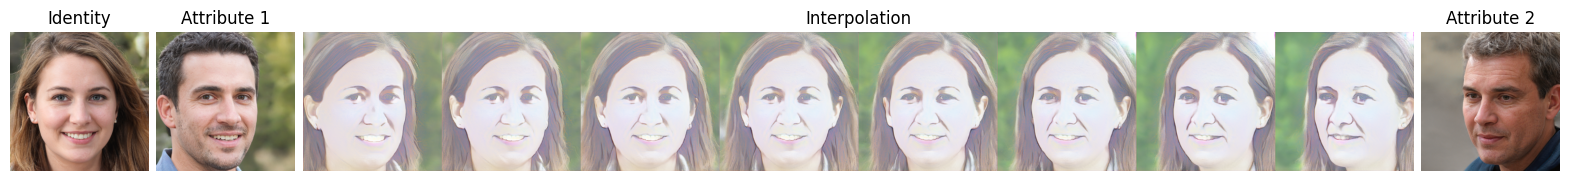

In [9]:
id_img = Image.open('./pretrained/fake/small_w/0/4.png')
attr_img1 = Image.open('./pretrained/fake/small_w/0/24.png')
attr_img2 = Image.open('./pretrained/fake/small_w/0/72.png')
generated_imgs = interpolate_attributes(id_img, attr_img1, attr_img2)
plot_attr_interpolation(generated_imgs, id_img, attr_img1, attr_img2)

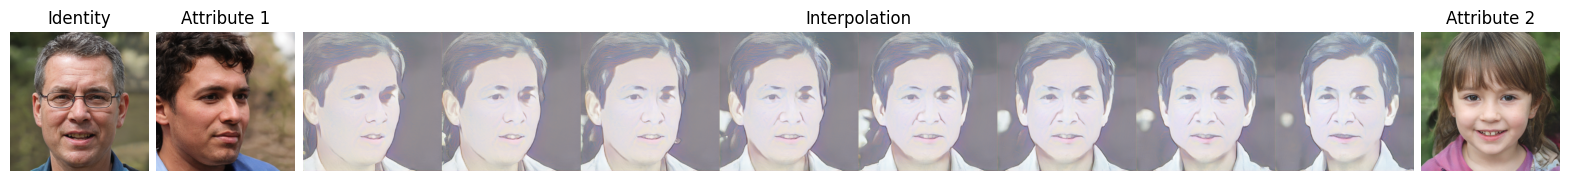

In [10]:
id_img = Image.open('./pretrained/fake/small_w/0/47.png')
attr_img1 = Image.open('./pretrained/fake/small_w/0/232.png')
attr_img2 = Image.open('./pretrained/fake/small_w/0/213.png')
generated_imgs = interpolate_attributes(id_img, attr_img1, attr_img2)
plot_attr_interpolation(generated_imgs, id_img, attr_img1, attr_img2)

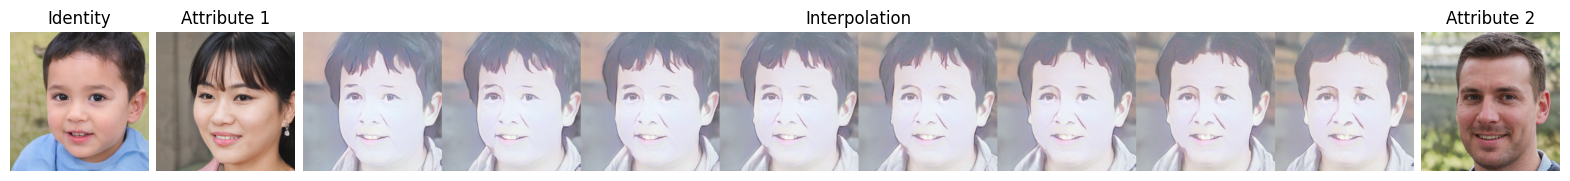

In [11]:
id_img = Image.open('./pretrained/fake/small_w/0/465.png')
attr_img1 = Image.open('./pretrained/fake/small_w/0/258.png')
attr_img2 = Image.open('./pretrained/fake/small_w/0/257.png')
generated_imgs = interpolate_attributes(id_img, attr_img1, attr_img2)
plot_attr_interpolation(generated_imgs, id_img, attr_img1, attr_img2)

# Identity Interpolation

In [12]:
def interpolate_identities(attr_img, id_img1, id_img2):
    attr_image = transform(attr_img)
    id_image1 = transform(id_img1)
    id_image2 = transform(id_img2)

    attr_image = convert_tensor(attr_image).to(Global_Config.device)
    id_image1 = convert_tensor(id_image1).to(Global_Config.device)
    id_image2 = convert_tensor(id_image2).to(Global_Config.device)

    id1 = torch.stack((id_image1, attr_image))
    id2 = torch.stack((id_image2, attr_image))
    atr1 = torch.stack((attr_image, id_image1))
    atr2 = torch.stack((attr_image, id_image2))

    concat_vec_cycled1 = get_concat_vec(id1, atr1, id_encoder, attr_encoder)
    concat_vec_cycled2 = get_concat_vec(id2, atr2, id_encoder, attr_encoder)

    with torch.no_grad():
        w1 = mlp(concat_vec_cycled1)[0]
        w2 = mlp(concat_vec_cycled2)[0]

    interpolated_w = []
    for i in range(8):
        interpolated_w.append(w1 + (w2 - w1) * (i / 7))
    interpolated_w = torch.stack(interpolated_w)

    generated_imgs = []
    for w in interpolated_w:
        generated_img = get_w_image(w, generator)
        generated_imgs.append(generated_img)
    generated_imgs = np.concatenate(np.array(generated_imgs), axis=1)
    return generated_imgs

In [13]:
def plot_id_interpolation(generated_imgs, attr_img, id_img1, id_img2):
    attr_img = np.array(transform(attr_img))
    id_img1 = np.array(transform(id_img1))
    id_img2 = np.array(transform(id_img2))

    fig, axes = plt.subplots(1, 4, figsize=(20, 20), gridspec_kw={'width_ratios': [1, 1, 8, 1]})
    axes[0].imshow(attr_img)
    axes[0].set_title('Attribute')
    axes[0].axis('off')
    axes[1].imshow(id_img1)
    axes[1].set_title('Identity 1')
    axes[1].axis('off')
    axes[2].imshow(generated_imgs)
    axes[2].set_title('Interpolation')
    axes[2].axis('off')
    axes[3].imshow(id_img2)
    axes[3].set_title('Identity 2')
    axes[3].axis('off')
    plt.subplots_adjust(wspace=0.02)
    plt.show()

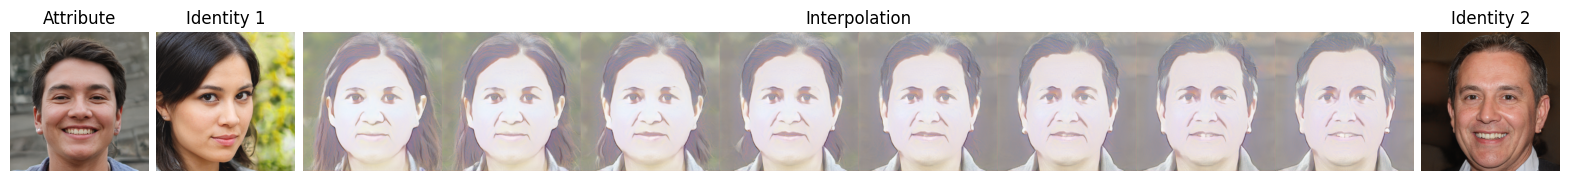

In [14]:
attr_img = Image.open('./pretrained/fake/small_w/0/6.png')
id_img1 = Image.open('./pretrained/fake/small_w/0/54.png')
id_img2 = Image.open('./pretrained/fake/small_w/0/89.png')
generated_imgs = interpolate_identities(attr_img, id_img1, id_img2)
plot_id_interpolation(generated_imgs, attr_img, id_img1, id_img2)

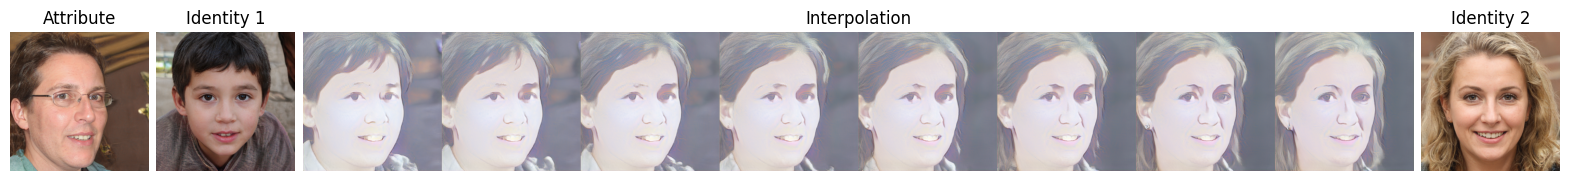

In [15]:
attr_img = Image.open('./pretrained/fake/small_w/0/176.png')
id_img1 = Image.open('./pretrained/fake/small_w/0/137.png')
id_img2 = Image.open('./pretrained/fake/small_w/0/136.png')
generated_imgs = interpolate_identities(attr_img, id_img1, id_img2)
plot_id_interpolation(generated_imgs, attr_img, id_img1, id_img2)

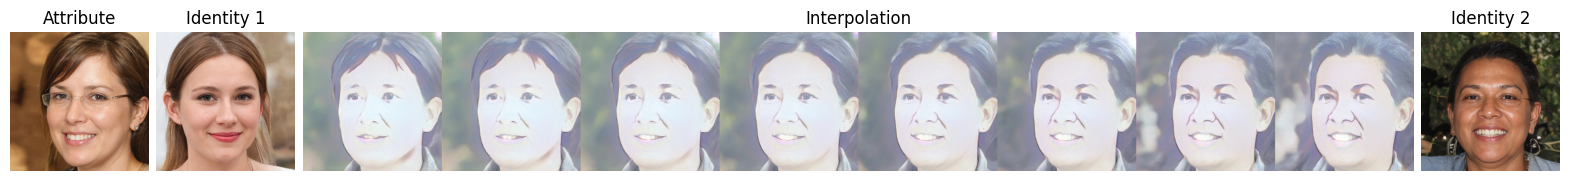

In [16]:
attr_img = Image.open('./pretrained/fake/small_w/0/564.png')
id_img1 = Image.open('./pretrained/fake/small_w/0/966.png')
id_img2 = Image.open('./pretrained/fake/small_w/0/81.png')
generated_imgs = interpolate_identities(attr_img, id_img1, id_img2)
plot_id_interpolation(generated_imgs, attr_img, id_img1, id_img2)

# Face Frontalization + Cartoonization

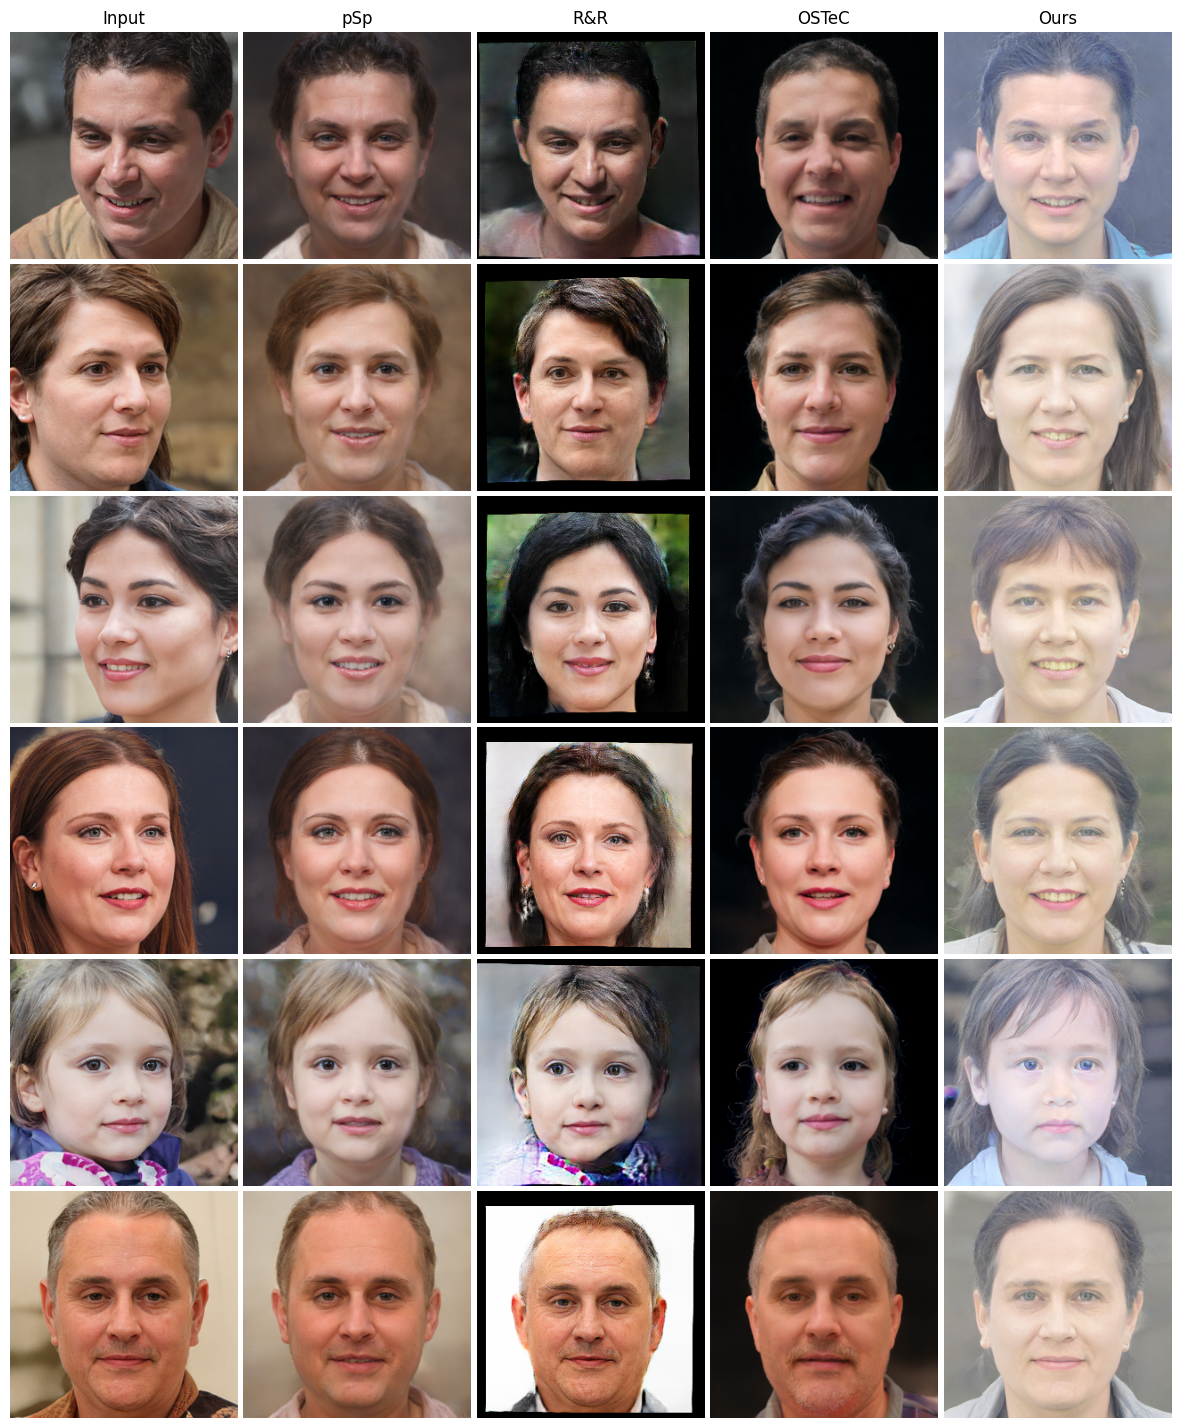

In [7]:
import glob
import matplotlib.pyplot as plt
import PIL.Image as Image

imgs = [82, 96, 223, 249, 270, 360]

# Plot folders of images as subplots
fig, axes = plt.subplots(6, 5, figsize=(15, 18))
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/input/' + str(img_id) + '.png'
    img = Image.open(img_path)
    axes[i][0].imshow(img)
    axes[i][0].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/pSp/' + str(img_id) + '_frontal.png'
    img = Image.open(img_path)
    axes[i][1].imshow(img)
    axes[i][1].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/R&R/' + str(img_id) + '_frontal.png'
    img = Image.open(img_path)
    axes[i][2].imshow(img)
    axes[i][2].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/OSTeC/' + str(img_id) + '_frontal.png'
    img = Image.open(img_path)
    axes[i][3].imshow(img)
    axes[i][3].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/ours/' + str(img_id) + '_frontal.png'
    img = Image.open(img_path)
    axes[i][4].imshow(img)
    axes[i][4].axis('off')
axes[0][0].set_title('Input')
axes[0][1].set_title('pSp')
axes[0][2].set_title('R&R')
axes[0][3].set_title('OSTeC')
axes[0][4].set_title('Ours')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

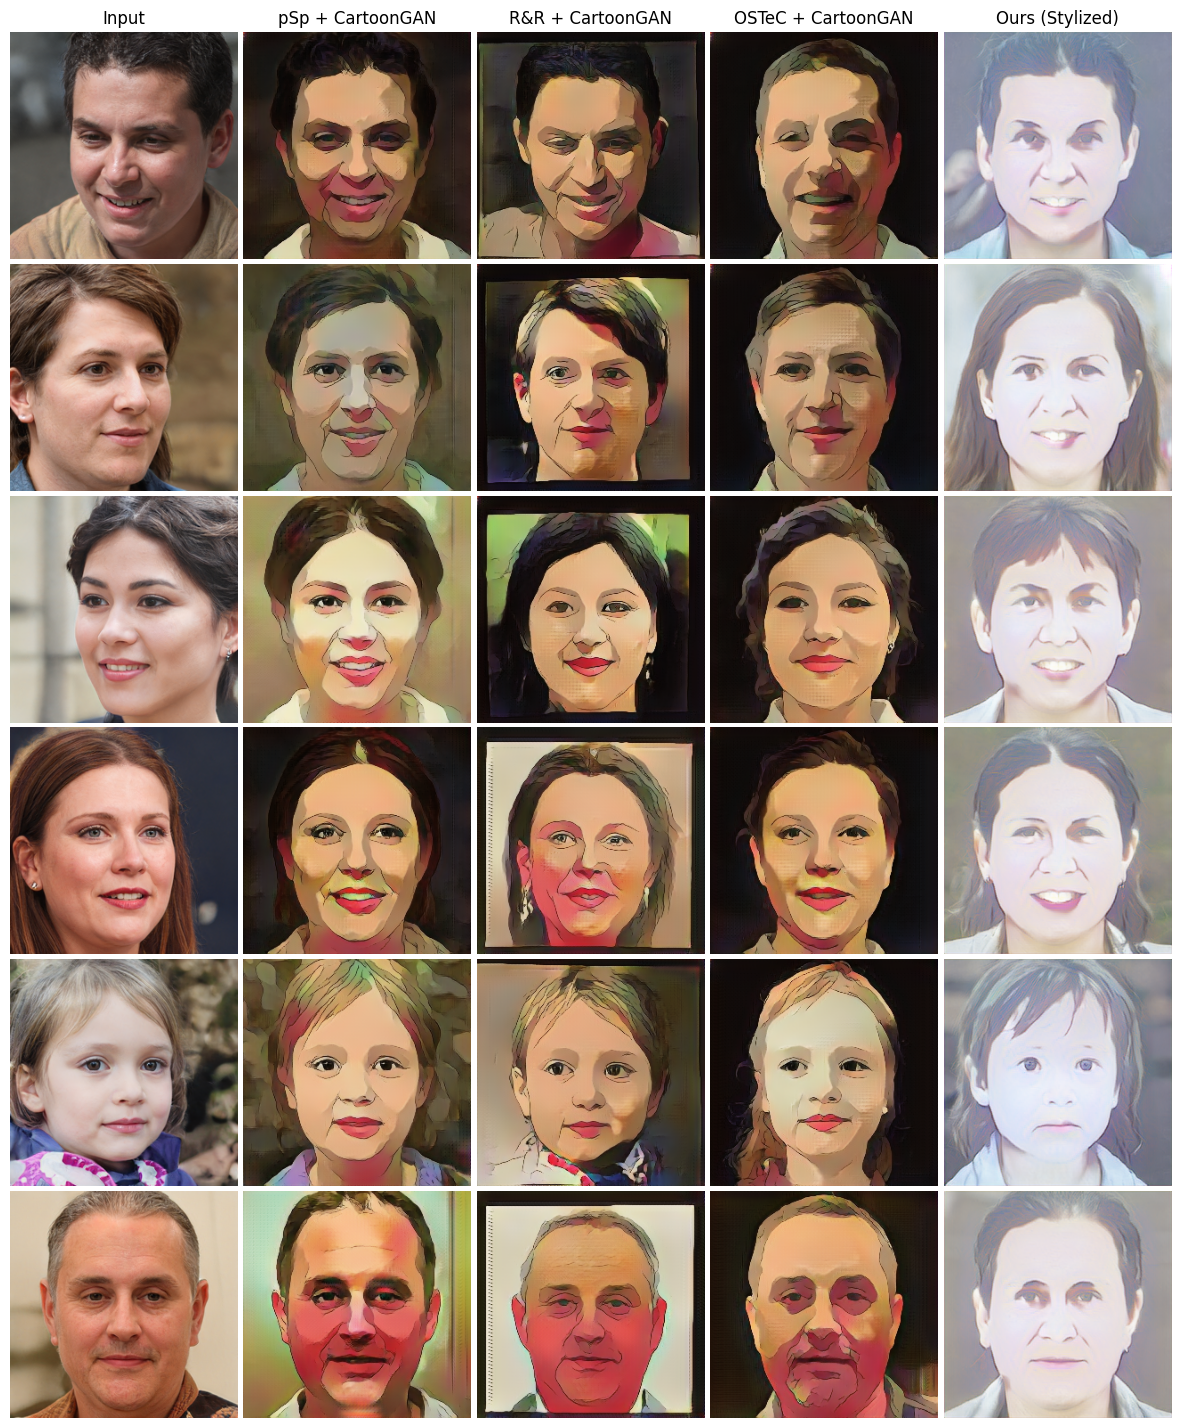

In [18]:
# Plot folders of images as subplots
fig, axes = plt.subplots(6, 5, figsize=(15, 18))
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/input/' + str(img_id) + '.png'
    img = Image.open(img_path)
    axes[i][0].imshow(img)
    axes[i][0].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/pSp/' + str(img_id) + '_cartoon.png'
    img = Image.open(img_path)
    axes[i][1].imshow(img)
    axes[i][1].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/R&R/' + str(img_id) + '_cartoon.png'
    img = Image.open(img_path)
    axes[i][2].imshow(img)
    axes[i][2].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/OSTeC/' + str(img_id) + '_cartoon.png'
    img = Image.open(img_path)
    axes[i][3].imshow(img)
    axes[i][3].axis('off')
for i, img_id in enumerate(imgs):
    img_path = './Experiments/Frontalization/ours/' + str(img_id) + '_cartoon.png'
    img = Image.open(img_path)
    axes[i][4].imshow(img)
    axes[i][4].axis('off')
axes[0][0].set_title('Input')
axes[0][1].set_title('pSp + CartoonGAN')
axes[0][2].set_title('R&R + CartoonGAN')
axes[0][3].set_title('OSTeC + CartoonGAN')
axes[0][4].set_title('Ours (Stylized)')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

In [10]:
def get_id_loss(img1, img2):
    _img1 = convert_tensor(transform(img1)).to(Global_Config.device).unsqueeze(0)
    _img2 = convert_tensor(transform(img2)).to(Global_Config.device).unsqueeze(0)
    if(_img2.shape[1] == 4):
        _img2 = _img2[:, :3, :, :]
    # id_stack = torch.stack((img1, img2))
    loss = id_encoder(_img1, _img2)
    del _img1, _img2
    torch.cuda.empty_cache()
    return loss.detach().cpu().numpy()

# ID Losses after frontalization

In [11]:
inputs = []
PsP = []
R_and_R = []
OSTeC = []
ours = []

for img_num in imgs:
    img_path = './Experiments/Frontalization/input/' + str(img_num) + '.png'
    img = Image.open(img_path)
    inputs.append(img)

    img_path = './Experiments/Frontalization/pSp/' + str(img_num) + '_frontal.png'
    img = Image.open(img_path)
    PsP.append(img)

    img_path = './Experiments/Frontalization/R&R/' + str(img_num) + '_frontal.png'
    img = Image.open(img_path)
    R_and_R.append(img)

    img_path = './Experiments/Frontalization/OSTeC/' + str(img_num) + '_frontal.png'
    img = Image.open(img_path)
    OSTeC.append(img)

    img_path = './Experiments/Frontalization/ours/' + str(img_num) + '_frontal.png'
    img = Image.open(img_path)
    ours.append(img)

# Tabulate losses between inputs and outputs using prettytable
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Input', 'pSp', 'R&R', 'OSTeC', 'Ours']
for i in range(len(imgs)):
    table.add_row(['Image ' + str(imgs[i]), get_id_loss(inputs[i], PsP[i]), get_id_loss(inputs[i], R_and_R[i]), get_id_loss(inputs[i], OSTeC[i]), get_id_loss(inputs[i], ours[i])])
print(table)

+-----------+------------+------------+------------+------------+
|   Input   |    pSp     |    R&R     |   OSTeC    |    Ours    |
+-----------+------------+------------+------------+------------+
|  Image 82 | 0.20350355 | 0.35985088 | 0.24328637 | 0.43156016 |
|  Image 96 | 0.16441655 | 0.29858816 | 0.22984207 | 0.5132224  |
| Image 223 | 0.19269574 | 0.31858367 | 0.2290079  | 0.64855653 |
| Image 249 | 0.1425842  | 0.38091528 | 0.26131767 |  0.434479  |
| Image 270 | 0.09782982 | 0.2545221  | 0.21840632 | 0.44999778 |
| Image 360 | 0.12790048 | 0.19378209 | 0.2138964  | 0.4645747  |
+-----------+------------+------------+------------+------------+


# ID Losses after Cartoonization

In [12]:
inputs = []
PsP = []
R_and_R = []
OSTeC = []
ours = []

for img_num in imgs:
    img_path = './Experiments/Frontalization/input/' + str(img_num) + '.png'
    img = Image.open(img_path)
    inputs.append(img)

    img_path = './Experiments/Frontalization/pSp/' + str(img_num) + '_cartoon.png'
    img = Image.open(img_path)
    PsP.append(img)

    img_path = './Experiments/Frontalization/R&R/' + str(img_num) + '_cartoon.png'
    img = Image.open(img_path)
    R_and_R.append(img)

    img_path = './Experiments/Frontalization/OSTeC/' + str(img_num) + '_cartoon.png'
    img = Image.open(img_path)
    OSTeC.append(img)

    img_path = './Experiments/Frontalization/ours/' + str(img_num) + '_cartoon.png'
    img = Image.open(img_path)
    ours.append(img)

# Tabulate losses between inputs and outputs using prettytable
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Input', 'pSp', 'R&R', 'OSTeC', 'Ours']
for i in range(len(imgs)):
    table.add_row(['Image ' + str(imgs[i]), get_id_loss(inputs[i], PsP[i]), get_id_loss(inputs[i], R_and_R[i]), get_id_loss(inputs[i], OSTeC[i]), get_id_loss(inputs[i], ours[i])])
print(table)

+-----------+------------+------------+------------+------------+
|   Input   |    pSp     |    R&R     |   OSTeC    |    Ours    |
+-----------+------------+------------+------------+------------+
|  Image 82 | 0.56685674 | 0.6050999  | 0.54419225 | 0.54026747 |
|  Image 96 | 0.5177221  | 0.51267225 | 0.5001581  | 0.5024831  |
| Image 223 | 0.5403193  | 0.68318534 | 0.7005758  | 0.7710658  |
| Image 249 | 0.5596113  | 0.70117384 | 0.6956685  | 0.5700983  |
| Image 270 | 0.46793205 | 0.4580242  | 0.5514858  | 0.6533016  |
| Image 360 | 0.40300256 | 0.51798785 | 0.43414712 | 0.63321257 |
+-----------+------------+------------+------------+------------+
